In [1]:
# データセット作成

!pip install scipy

clip_size = 40960 # clips.npy ファイルを DL してきた場合はこの値は変更しないでください
window_size = 4096
window_num_per_clip = int(clip_size / window_size)

from scipy.io.wavfile import read
import glob
import os
import numpy as np

if os.path.isfile("../data/arrays/clips.npy"):
    print("clips.npy exists.")
    clips = np.load("../data/arrays/clips.npy")
else:
    files = glob.glob("../data/wav44100/*")
    #files = ["../data/wav44100/3DEmbodimentFromLines.wav"]
    raw_data_list = [read(file)[1] for file in files]

    clips = np.zeros((0, clip_size), dtype=np.int16)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, clip_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save("../data/arrays/clips", clips)
    
if os.path.isfile("../data/arrays/fft_log_" + str(window_size) + ".npy"):
    print("fft_log_" + str(window_size) + ".npy exists.")
    fft = np.load("../data/arrays/fft_log_" + str(window_size) + ".npy")
else:
    fft = np.zeros((0, window_num_per_clip, window_size))
    num = 0
    for clip in clips:
        print("fft progress: clip " + str(num))
        
        fft_tmp = np.zeros((0, window_size))
        tmp = [clip[i:i + window_size] for i in range(0, len(clip) - window_size + 1, window_size)]
        for tmp2 in tmp:
            spectrum = np.abs(np.fft.fft(tmp2))
            spectrum = np.log(spectrum + 1) / np.log(np.finfo(np.float64).max)
            fft_tmp = np.vstack((fft_tmp, spectrum))
        fft = np.vstack((fft, fft_tmp.reshape(1, window_num_per_clip, window_size)))
        num += 1

    np.save("../data/arrays/fft_log_" + str(window_size), fft)
    
print("clips.shape: " + str(clips.shape))
print("fft.shape: " + str(fft.shape))

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
clips.npy exists.
fft_log_4096.npy exists.
clips.shape: (255, 40960)
fft.shape: (255, 10, 4096)


In [2]:
# 学習データとテストデータに分ける

train_data_rate = 0.8

fft_sum_threshold = 1 # 1 window の sum(log(fft)) が閾値に満たないときに除外します

def normalize(array):
    if (np.sum(array) == 0):
        return array
    else:
        return array / np.sum(array)

fft = np.concatenate([fft[:-1, :, :], fft[1:, 0, :].reshape(fft.shape[0] - 1, 1, fft.shape[2])], 1)

clips = np.delete(clips, np.where(np.sum(fft[:,0,:], axis=1) < fft_sum_threshold)[0], axis=0)
fft = np.delete(fft, np.where(np.sum(fft[:,0,:], axis=1) < fft_sum_threshold)[0], axis=0)

fft = np.apply_along_axis(normalize, 2, fft)

p = np.random.permutation(len(fft))
fft = fft[p]
clips = clips[p]

x_train = fft[:int(fft.shape[0] * train_data_rate), :window_num_per_clip, :].reshape(int(fft.shape[0] * train_data_rate), window_num_per_clip, window_size, 1)
x_test = fft[int(fft.shape[0] * train_data_rate):, :window_num_per_clip, :].reshape(fft.shape[0] - int(fft.shape[0] * train_data_rate), window_num_per_clip, window_size, 1)
y_train = fft[:int(fft.shape[0] * train_data_rate), window_num_per_clip, :]
y_test = fft[int(fft.shape[0] * train_data_rate):, window_num_per_clip, :]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(np.max(x_train[0]))

(203, 10, 4096, 1)
(51, 10, 4096, 1)
(203, 4096)
(51, 4096)
0.0006183653007691288


In [3]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
# モデル作成

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, Input
from keras.optimizers import Adam

learning_rate = 0.0001
 
model = keras.models.Sequential()
model.add(Conv2D(3, (3, 1), activation='relu', input_shape=(window_num_per_clip, window_size, 1)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=window_size))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 4096, 3)        12        
                                                                 
 dropout (Dropout)           (None, 8, 4096, 3)        0         
                                                                 
 flatten (Flatten)           (None, 98304)             0         
                                                                 
 dense (Dense)               (None, 512)               50332160  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4096)              2

In [5]:
# 学習
batch_size = 256
epochs = 100
model_name = "fft_batch" + str(batch_size) + "_e" + str(epochs)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

model.save("../data/models/" + model_name)

1/1 [==============================] - 1s 908ms/step - loss: 8.3178 - accuracy: 0.0000e+00 - val_loss: 8.3178 - val_accuracy: 0.0000e+00


INFO:tensorflow:Assets written to: ../data/models/fft_batch256_e1/assets


INFO:tensorflow:Assets written to: ../data/models/fft_batch256_e1/assets


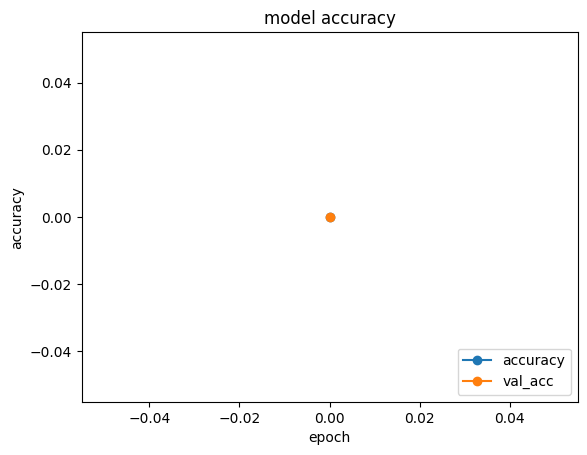

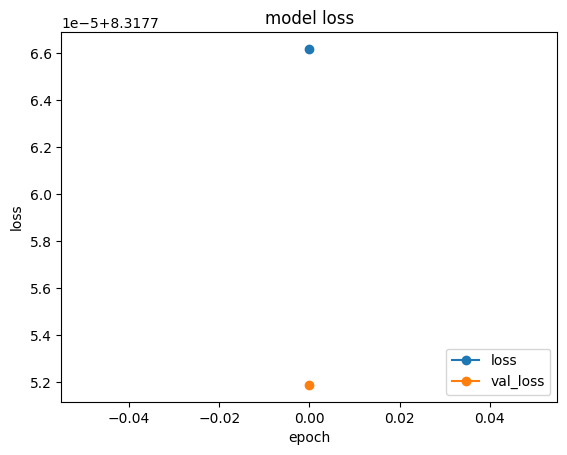

In [6]:
# loss 遷移のプロット

import matplotlib.pyplot as plt

plot_history(history)

In [7]:
# 楽曲の出力

!pip install scikit-learn

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy.io import wavfile
from keras.models import load_model

model = load_model("../data/models/" + model_name)
file_name = "out_" + model_name

first_index = np.random.randint(0, len(x_test))
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = -1
    for spectrum in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if tmp_sim > cos_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index + int(fft.shape[0] * train_data_rate)]))
    
wavfile.write("../data/out/" + file_name + "_1.wav", 44100, out)

first_index = np.random.randint(0, len(x_test))
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = -1
    for spectrum in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if tmp_sim > cos_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index + int(fft.shape[0] * train_data_rate)]))
    
wavfile.write("../data/out/" + file_name + "_2.wav", 44100, out)

first_index = np.random.randint(0, len(x_test))
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = -1
    for spectrum in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if tmp_sim > cos_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index + int(fft.shape[0] * train_data_rate)]))
    
wavfile.write("../data/out/" + file_name + "_3.wav", 44100, out)

     |████████████████████████████████| 9.8 MB 9.9 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 11.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
1/1 [==============================] - 0s 70ms/step
49
1/1 [==============================] - 0s 26ms/step
49
1/1 [==============================] - 0s 26ms/step
49
1/1 [==============================] - 0s 28ms/step
49
1/1 [==============================] - 0s 31ms/step
49
1/1 [==============================] - 0s 29ms/step
49
1/1 [==============================] - 0s 27ms/step
49
1/1 [==============================] - 0s 26ms/step
49
1/1 [==============================] - 0s 26ms/step
49
1/1 [==============================] - 0s 29ms/step
49
1/1 [==============================] - 0s 30ms/step
49
1/1 [==============================] - 0s 29ms/step
49
1/1 [==============================] - 0s 29ms/step
49
1/1 [==============================] - 0s 29ms/step
4